CSE6250_TEAM_L4 FINAL PROJECT

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Introduction
This research paper attempts to recreate paper on Temporal Self-Attention Network for MedicalConcept Embedding.  The paper primarity atempts to use word embedding approaches to learn a low-dimensional dense representation of medical concepts. It is essentially a feature engineeing and  data processing problem. This is a verry impornt problem to explore as it allows to standardize healthcare data. The paper suggests tree based embedding however it comes with two major difficulties. First embedding ignores the time period between visits. Secondly,  tree-based embedding methods cannot reflect the complex relationships between each unit of the medical concepts because of the hierarchical representation.  

The paper proposes a Temporal Self attention Network model named TeSAN. Given an input sequence of concept representation c, which is from concatenated visits in one patient journey, TeSAN first applies the TeSA block to capture the contextual relationship and temporal interval information. The multi-dimensional attention pooling block takes the TeSA output as input to produce hi ∈ ℝd. Tjis model was compared on two datasets MIMIC III and CMS. TeSAN's performance was compared to five other moelds CBOW, Skip-gram, GloVe, med2vecand MCE. In order to evaluate the effectiveness of the algorithm, two clustering algorithms were used. From the results we can see TeSAN outperformed all the baseline algorithms on both datasets by achiveing highest accuracies. This makes the paper an importnat contribution to the regime as it sugests TeSAN is a highly effective algorithm that allows faser and more accurate feature embeding.  



# Scope of Reproducibility:

List hypotheses from the paper to test.


1.   Hypothesis 1:When comparing the models a CMS data will lead to much more accurate resuts with a higher accuracy score for clustering algorithms.
2.   Hypothesis 2: When comparing the models and data sets CCS codes lead to a better feature for modeling and then ICD scores for culustering




# Methodology



In [2]:
# import  packages you need
import numpy as np
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import json
import datetime
import tensorflow as tf
import tensorflow.compat.v1 as tf

##  Data
The Orignal paper performs the research on two seperate data sets MIMIC III and CMS dataset. Inorder to scale the research paper down and allow it to fit the timeframe and scope of the project, this recreation will only use the CMS dataset. [CMS](https://data.cms.gov/collection/synthetic-medicare-enrollment-fee-for-service-claims-and-prescription-drug-event)  is a publicly available synthetic claims dataset, which includes four types of files: inpatient, outpatient, carrier and beneficiary summary. To replicate the data from the orignal paper, we will also only use a subset of inpatient files between 2008 and 2010.  

  
  * Statistics: include basic descriptive statistics of the dataset like size, cross validation split, label distribution, etc.
  * Data process: how do you munipulate the data, e.g., change the class labels, split the dataset to train/valid/test, refining the dataset.
  * Illustration: printing results, plotting figures for illustration.
  * You can upload your raw dataset to Google Drive and mount this Colab to the same directory. If your raw dataset is too large, you can upload the processed dataset and have a code to load the processed dataset.

Note: For TA to grade My submission, I have shared access to the following TAs.

*   Quan Guo: gqsavannah@gmail.com
*   Yuzheng Liu: liuyz0218@gmail.com
*   Bojun Li: bojunli412@gmail.com
*   Jinhan Zhao: walt980626@gmail.com



In [3]:
cols = ['DESYNPUF_ID', 'CLM_ADMSN_DT', 'CLM_UTLZTN_DAY_CNT', 'CLM_DRG_CD',
        'ICD9_DGNS_CD_1', 'ICD9_DGNS_CD_2', 'ICD9_DGNS_CD_3','ICD9_DGNS_CD_4','ICD9_DGNS_CD_5',
        'ICD9_DGNS_CD_6', 'ICD9_DGNS_CD_7', 'ICD9_DGNS_CD_8','ICD9_DGNS_CD_9','ICD9_DGNS_CD_10',
        'ICD9_PRCDR_CD_1','ICD9_PRCDR_CD_2','ICD9_PRCDR_CD_3','ICD9_PRCDR_CD_4','ICD9_PRCDR_CD_5',
        'ICD9_PRCDR_CD_6']


def processing_cms():
    source_path ='./drive/MyDrive/Colab Notebooks/cmsdata'
    output_file ='./drive/MyDrive/Colab Notebooks/patients_cms_full.json'
    all_files = glob.glob(source_path + "/*.csv")
     # use your path
    list_ = []
    for file_ in all_files:
        df = pd.read_csv(file_, index_col=None, dtype=object, header=0)

        list_.append(df)
    #print(list_)
    frame = pd.concat(list_)

    data = frame[cols]
    unique_pats = data.DESYNPUF_ID.unique()
    grouped = data.groupby(['DESYNPUF_ID'])


    #     samples = unique_pats[range(1000)]
    patients = []
    total_visits=0
    all_diag_codes =[]
    all_pro_codes=[]

    for sub_id in unique_pats:
        patient = dict()
        patient['pid'] = sub_id
        visits = []

        acts = grouped.get_group(sub_id)
        for index, row in acts.iterrows():
            act = dict()
            admsn_dt = row['CLM_ADMSN_DT']
            day_cnt = row['CLM_UTLZTN_DAY_CNT']
            # skip if admision or discharge data is null
            if admsn_dt != admsn_dt:
                continue
            act['admsn_dt'] = admsn_dt
            act['day_cnt'] = day_cnt
            DXs = []
            for i in range(10):
                dx = row['ICD9_DGNS_CD_' + str(i + 1)]
                # if dx is not NaN
                if dx == dx:
                    DXs.append(dx)
            act['DXs'] = DXs
            CPTs = []
            for i in range(6):
                cpt = row['ICD9_PRCDR_CD_' + str(i + 1)]
                # if cpt is not NaN
                if cpt == cpt:
                    CPTs.append(cpt)
            act['CPTs'] = CPTs
            act['drg'] = row['CLM_DRG_CD']
            visits.append(act)
            all_diag_codes.extend(DXs)
            all_pro_codes.extend(CPTs)
        patient['visits'] = visits
        patients.append(patient)
        total_visits += len(visits)

    print(" Statistics of CMS Dataset")
    print("total patient: ",len(unique_pats))
    print("total visits: ",total_visits )
    print("Average visits per patient: ", total_visits/len(patients))
    print("Diag code: ", len(all_diag_codes))
    print("Procedure code: ", len(all_pro_codes))

    with open(output_file, 'w') as outfile:
        json.dump(patients, outfile)

    return patients


In [ ]:
def processing_mimic3(file_adm, file_dxx, file_txx, file_drug, file_drg, output_file):

    m_adm = pd.read_csv(file_adm, dtype={'HOSPITAL_EXPIRE_FLAG': object})
    m_dxx = pd.read_csv(file_dxx, dtype={'ICD9_CODE': object})
    m_txx = pd.read_csv(file_txx, dtype={'ICD9_CODE': object})
    m_drg = pd.read_csv(file_drg, dtype={'DRG_CODE': object})
    m_drug = pd.read_csv(file_drug, dtype={'NDC': object})

    # get total unique patients
    unique_pats = m_dxx.SUBJECT_ID.unique()

    patients = []  # store all preprocessed patients' data
    for sub_id in unique_pats:
        patient = dict()
        patient['pid'] = str(sub_id)
        pat_dxx = m_dxx[m_dxx.SUBJECT_ID == sub_id]  # get a specific patient's all data in dxx file
        uni_hadm = pat_dxx.HADM_ID.unique()  # get all unique admissions
        grouped = pat_dxx.groupby(['HADM_ID'])
        visits = []
        for hadm in uni_hadm:
            act = dict()
            adm = m_adm[(m_adm.SUBJECT_ID == sub_id) & (m_adm.HADM_ID == hadm)]
            admsn_dt = datetime.datetime.strptime(adm.ADMITTIME.values[0], "%Y-%m-%d %H:%M:%S")
            disch_dt = datetime.datetime.strptime(adm.DISCHTIME.values[0], "%Y-%m-%d %H:%M:%S")
            death_flag = adm.HOSPITAL_EXPIRE_FLAG.values[0]

            delta = disch_dt - admsn_dt
            act['admsn_dt'] = admsn_dt.strftime("%Y%m%d")
            act['day_cnt'] = str(delta.days + 1)

            codes = grouped.get_group(hadm)  # get all diagnosis codes in the adm
            DXs = []
            for index, row in codes.iterrows():
                dx = row['ICD9_CODE']
                # if dx is not NaN
                if dx == dx:
                    DXs.append(dx)

            TXs = []
            pat_txx = m_txx[(m_txx.SUBJECT_ID == sub_id) & (m_txx.HADM_ID == hadm)]
            tx_codes = pat_txx.ICD9_CODE.values  # get all procedure codes in the adm
            for code in tx_codes:
                if code == code:
                    TXs.append(code)

            drugs = []
            pat_drugs = m_drug[(m_drug.SUBJECT_ID == sub_id) & (m_drug.HADM_ID == hadm)]
            drug_codes = pat_drugs.NDC.values  # get all drug codes in the adm
            for code in drug_codes:
                if code == code and code != '0':
                    drugs.append(code)

            drgs = []
            pat_drgs = m_drg[(m_drg.SUBJECT_ID == sub_id) & (m_drg.HADM_ID == hadm)]
            drg_codes = pat_drgs.DRG_CODE.values  # get all drug codes in the adm
            for code in drg_codes:
                if code == code:
                    drgs.append(code)

            act['DXs'] = DXs
            act['CPTs'] = TXs
            act['DRGs'] = drgs
            act['Drugs'] = drugs
            act['Death'] = death_flag
            visits.append(act)
        print('patient {} is processed!'.format(sub_id))
        patient['visits'] = visits
        patients.append(patient)

    with open(output_file, 'w') as outfile:
        json.dump(patients, outfile)

    return patients



In [90]:
# dir and function to load raw data
# you must share this dir to graders/TAs (gmail) to grant them data access
# Otherwise TA cannot grade your submission



def load_raw_data():
  # implement this function to load raw data to dataframe/numpy array/tensor
  source_path ='./drive/MyDrive/Colab Notebooks/cmsdata'
  output_file ='./drive/MyDrive/Colab Notebooks/patients_cms_full.json'
  all_files = glob.glob(source_path + "/*.csv")

  # use your path
  list_ = []
  for file_ in all_files:
      df = pd.read_csv(file_, index_col=None, dtype=object, header=0)
      df = df.dropna()
      list_.append(df)

  frame = pd.concat(list_)
  data = frame[cols]
  return data


# calculate statistics
def calculate_stats(raw_data):
  # implement this function to calculate the statistics
  # it is encouraged to print out the results

  return None

# process raw data
def process_data(raw_data):
    # implement this function to process the data as you need
    mimic_flag = False

    if mimic_flag:
        file_adm = './drive/MyDrive/Colab Notebooks//mimic3/ADMISSIONS.csv'
        file_dxx = './drive/MyDrive/Colab Notebooks//mimic3/DIAGNOSES_ICD.csv'
        file_txx = './drive/MyDrive/Colab Notebooks//mimic3/PROCEDURES_ICD.csv'
        file_drug = './drive/MyDrive/Colab Notebooks//mimic3/PRESCRIPTIONS.csv'
        file_drg = './drive/MyDrive/Colab Notebooks/mimic3/DRGCODES.csv'

        output_file = './drive/MyDrive/Colab Notebooks/patients_cms_full.json'
        processing_mimic3(file_adm, file_dxx, file_txx, file_drug, file_drg, output_file)

    else:
        files_path = '../../dataset/cms'
        output_file = './drive/MyDrive/Colab Notebooks/patients_cms_full.json'
        processing_cms()

raw_data = load_raw_data()
processed_data = process_data(raw_data)

calculate_stats(raw_data)

 Statistics of CMS Dataset
total patient:  188559
total visits:  332606
Average visits per patient:  1.7639359563850041
Diag code:  2678053
Procedure code:  476587


##   Model
The model includes the model definitation which usually is a class, model training, and other necessary parts.
  * Model architecture: layer number/size/type, activation function, etc
  * Training objectives: loss function, optimizer, weight of each loss term, etc
  * Others: whether the model is pretrained, Monte Carlo simulation for uncertainty analysis, etc
  * The code of model should have classes of the model, functions of model training, model validation, etc.
  * If your model training is done outside of this notebook, please upload the trained model here and develop a function to load and test it.

In [69]:
NOTE: The model is crearted in the MODEL.PY file in the template folder. SOme parts of the model is added below to show as a refrese what the model creation process looks like.

SyntaxError: invalid syntax (<ipython-input-69-e4d9e6f85483>, line 1)

In [ ]:
class ConceptModel():
    def __init__(self,scope,dataset):
        super(ConceptModel, self).__init__(scope,dataset)

        # ------ start ------
        self.context_fusion = None

        self.code_embeddings = None
        self.final_embeddings = None

        self.nce_weights = None
        self.final_weights = None

        self.final_wgt_sim = None
        self.final_emb_sim = None

        self.context_dates = None
        self.train_masks = None

        # ---- place holder -----
        if self.is_date_encoding:
            self.train_inputs = tf.placeholder(tf.int32, shape=[None, None, 3], name='train_inputs')
            self.context_dates = self.train_inputs[:, :, 2]
        else:
            self.train_inputs = tf.placeholder(tf.int32, shape=[None, None, 2], name='train_inputs')
            self.train_masks = tf.placeholder(tf.int32, shape=[None, None, None], name='train_masks')

        self.train_labels = tf.placeholder(tf.int32, shape=[None, 1], name='train_labels')
        self.valid_dataset = tf.constant(self.valid_samples, dtype=tf.int32, name='valid_samples')

        # ------------ other ---------
        self.output_class = 3  # 0 for contradiction, 1 for neural and 2 for entailment
        self.batch_size = tf.shape(self.train_inputs)[0]
        self.code_len = tf.shape(self.train_inputs)[1]

        # context codes
        self.context_codes = self.train_inputs[:, :, 0]

        # mask for padding codes are all 0, actual codes are 1
        self.context_mask = tf.cast(self.context_codes, tf.bool)

        # time interval between context code and label code
        self.context_delta = self.train_inputs[:, :, 1]

        #building model and other parts
        self.context_fusion, self.code_embeddings = self.build_network()
        self.loss, self.optimizer, self.nce_weights = self.build_loss_optimizer()
        self.final_embeddings, self.final_weights = self.build_embedding()
        self.final_emb_sim, self.final_wgt_sim = self.build_similarity()

    def build_loss_optimizer(self):

        # Construct the variables for the NCE loss
        with tf.name_scope('weights'):
            nce_weights = tf.Variable(
                tf.truncated_normal([self.vocabulary_size, self.embedding_size],
                                    stddev=1.0 / math.sqrt(self.embedding_size)))
        with tf.name_scope('biases'):
            nce_biases = tf.Variable(tf.zeros([self.vocabulary_size]))

        losses = tf.nn.nce_loss(
            weights=nce_weights,
            biases=nce_biases,
            labels=self.train_labels,
            inputs=self.context_fusion,
            num_sampled=self.num_samples,
            num_classes=self.vocabulary_size)

        # loss = tf.reduce_mean(losses, name='loss_mean')
        tf.add_to_collection('losses', tf.reduce_mean(losses, name='loss_mean'))
        loss = tf.add_n(tf.get_collection('losses', self.scope), name='loss')
        tf.summary.scalar(loss.op.name, loss)
        tf.add_to_collection('ema/scalar', loss)

        optimizer = tf.train.AdamOptimizer().minimize(loss)
        return loss, optimizer, nce_weights

    def build_accuracy(self):
        pass

    def build_network(self):
        # Look up embeddings for inputs.
        with tf.name_scope('code_embeddings'):
            init_code_embed = tf.random_uniform([self.vocabulary_size, self.embedding_size], -1.0, 1.0)
            code_embeddings = tf.Variable(init_code_embed)
            context_embed = tf.nn.embedding_lookup(code_embeddings, self.context_codes)

        if self.model_type == 'tesa':
            with tf.name_scope(self.model_type):
                # Embedding size is calculated as shape(train_inputs) + shape(embeddings)[1:]
                init_date_embed = tf.random_uniform([self.dates_size, self.embedding_size], -1.0, 1.0)
                date_embeddings = tf.Variable(init_date_embed)

                if self.is_date_encoding:
                    date_embed = tf.nn.embedding_lookup(date_embeddings, self.context_dates)

                    # self_attention
                    cntxt_embed = temporal_date_sa_with_dense(rep_tensor=context_embed,
                                                              rep_mask=self.context_mask,
                                                              date_tensor=date_embed,
                                                              is_train=True,
                                                              activation=self.activation,
                                                              is_scale = self.is_scale)
                else:
                    date_embed = tf.nn.embedding_lookup(date_embeddings, self.train_masks)

                    # self_attention
                    cntxt_embed = temporal_delta_sa_with_dense(rep_tensor=context_embed,
                                                               rep_mask=self.context_mask,
                                                               delta_tensor = date_embed,
                                                               is_train=True,
                                                               activation=self.activation,
                                                               is_scale = self.is_scale)

                # Attention pooling
                context_fusion = multi_dimensional_attention(cntxt_embed,self.context_mask,is_train=True)

        elif self.model_type == 'delta':
            with tf.name_scope(self.model_type):
                #self_attention
                init_date_embed = tf.random_uniform([self.dates_size, self.embedding_size], -1.0, 1.0)
                date_embeddings = tf.Variable(init_date_embed)
                date_embed = tf.nn.embedding_lookup(date_embeddings, self.train_masks)
                cntxt_embed = delta_with_dense(rep_tensor=context_embed,
                                                        rep_mask=self.context_mask,
                                                        delta_tensor=date_embed,
                                                        is_train=True,
                                                        activation=self.activation,
                                                        is_scale = self.is_scale)

                # attention pooling
                context_fusion = multi_dimensional_attention(cntxt_embed,self.context_mask,is_train=True)

        elif self.model_type == 'sa':
            with tf.name_scope(self.model_type):
                #self_attention
                cntxt_embed = self_attention_with_dense(rep_tensor=context_embed,
                                                        rep_mask=self.context_mask,
                                                        is_train=True,
                                                        activation=self.activation,
                                                        is_scale = self.is_scale)

                # attention pooling
                context_fusion = multi_dimensional_attention(cntxt_embed,self.context_mask,is_train=True)

        elif self.model_type == 'normal':
            with tf.name_scope(self.model_type):
                #self_attention
                cntxt_embed = normal_attention(rep_tensor=context_embed,
                                                        rep_mask=self.context_mask,
                                                        is_train=True,
                                                        activation=self.activation)

                # attention pooling
                context_fusion = multi_dimensional_attention(cntxt_embed,self.context_mask,is_train=True)

        elif self.model_type == 'cbow':
            with tf.name_scope(self.model_type):
                cntxt_embed = mask_for_high_rank(context_embed, self.context_mask)# bs,sl,vec
                context_fusion = tf.reduce_mean(cntxt_embed, 1)

        elif self.model_type == 'ta_attn':
            context_fusion = time_aware_attention(self.train_inputs,context_embed,self.context_mask,self.embedding_size,k=100)

        elif self.model_type == 'fusion':
            with tf.name_scope(self.model_type):
                # self-attention
                code2code = self_attention_with_dense(rep_tensor=context_embed, rep_mask=self.context_mask,
                                                      is_train=True,activation=self.activation)
                # attention pooling
                source2code = multi_dimensional_attention(code2code,self.context_mask,is_train=True)
                # time-aware attention
                ta_attn_res = time_aware_attention(self.train_inputs,context_embed,self.context_mask,self.embedding_size,k=100)

                ivec = ta_attn_res.get_shape()[1]
                concat_context = tf.concat([source2code, ta_attn_res], 1)

                # context_fusion = fusion_gate(source2code,ta_attn_res,wd=0., keep_prob=1., is_train=True)
                context_fusion = bn_dense_layer(concat_context,ivec,True, 0., 'bn_dense_map', self.activation,
                                        False, wd=0., keep_prob=1., is_train=True)
        return context_fusion, code_embeddings

    def build_embedding(self):
        with tf.name_scope('build_embedding'):
            # Compute the cosine similarity between minibatch examples and all embeddings.
            norm = tf.sqrt(tf.reduce_sum(tf.square(self.code_embeddings), 1, keepdims =True))
            final_embeddings = self.code_embeddings / norm

            weights_norm = tf.sqrt(tf.reduce_sum(tf.square(self.nce_weights), 1, keepdims=True))
            final_weights = self.nce_weights / weights_norm
        return final_embeddings, final_weights

    def build_similarity(self):
        with tf.name_scope('build_similarity'):
            valid_embeddings = tf.nn.embedding_lookup(self.final_embeddings, self.valid_dataset)
            final_emb_sim = tf.matmul(valid_embeddings, self.final_embeddings, transpose_b=True)

            valid_embeddings = tf.nn.embedding_lookup(self.final_weights, self.valid_dataset)
            final_wgt_sim = tf.matmul(valid_embeddings, self.final_weights, transpose_b=True)

        return final_emb_sim, final_wgt_sim

In [52]:
!pip install --upgrade tf_slim

In [72]:
import tensorflow.compat.v1 as tf
import numpy as np
from os.path import join
import sys

#ys.path.append("/content/my_module.py")

from src.utils.configs import cfg
from src.embedding.concept.evaluation import ConceptEvaluation as Evaluator
from src.embedding.concept.model import ConceptModel as Model

from src.utils.graph_handler import GraphHandler
from src.utils.record_log import RecordLog
from src.embedding.concept.dataset import  ConceptDataset as CDataset
from src.embedding.concept.datasetEncodeDate import ConceptAndDateDataset as CDDataset

import warnings
warnings.filterwarnings('ignore')

logging = RecordLog()
def train():

    if cfg.gpu_mem is None:
        gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=cfg.gpu_mem, allow_growth=True)
        graph_config = tf.ConfigProto(gpu_options=gpu_options, allow_soft_placement=True)
    else:
        gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=cfg.gpu_mem)
        graph_config = tf.ConfigProto(gpu_options=gpu_options)

    num_steps = cfg.num_steps

    if cfg.is_date_encoding:
        data_set = CDDataset()
        data_set.prepare_data(cfg.visit_threshold)
        data_set.build_dictionary()
        data_set.build_dict4date()
        data_set.load_data()
        sample_batches = data_set.generate_batch(num_steps)
    else:
        data_set = CDataset()
        data_set.prepare_data(cfg.visit_threshold)
        data_set.build_dictionary()
        data_set.load_data()
        sample_batches = data_set.generate_batch(num_steps)
        print(data_set.train_size)
        batch_num = data_set.train_size / data_set.batch_size
        print(batch_num)

    sess = tf.Session(config=graph_config)
    with tf.variable_scope('concept_embedding') as scope:
        model = Model(scope.name,data_set)

    graph_handler = GraphHandler(model,logging)
    graph_handler.initialize(sess)
    evaluator = Evaluator(model,logging)

    global_step = 0
    total_loss = 0

    epoch_loss = 0
    tmp_epoch = 0
    tmp_cur_batch = 0

    logging.add()
    logging.add('Begin training...')
    for batch in sample_batches:
        if num_steps is not None: # run based on step number
            if cfg.is_date_encoding:
                feed_dict = {model.train_inputs: batch[0], model.train_labels: batch[1]}
            else:
                feed_dict = {model.train_inputs: batch[0], model.train_labels: batch[2], model.train_masks: batch[1]}
            _, loss_val = sess.run([model.optimizer, model.loss], feed_dict=feed_dict)
            total_loss += loss_val
            global_step += 1

            if global_step % 5000 == 0:
                avg_loss = total_loss / 1000
                log_str = "Average loss at step %s: %s " % (global_step, avg_loss)
                logging.add(log_str)
                total_loss = 0

                icd_nns = evaluator.get_nns_p_at_top_k(sess, 'ICD')
                icd_weigh_scores = evaluator.get_clustering_nmi(sess, 'ICD')
                ccs_nns = evaluator.get_nns_p_at_top_k(sess, 'CCS')
                ccs_weigh_scores = evaluator.get_clustering_nmi(sess, 'CCS')

                logging.add('validating the embedding performance .....')
                log_str = "weight: %s %s %s %s" % (icd_weigh_scores, ccs_weigh_scores, icd_nns, ccs_nns)
                logging.add(log_str)
        else: # run based on epoch number
            if cfg.is_date_encoding:
                batch_num, current_epoch, current_batch = batch[2], batch[3], batch[4]
            else:
                batch_num, current_epoch, current_batch = batch[3], batch[4], batch[5]

            if tmp_epoch != current_epoch:
                epoch_loss /= tmp_cur_batch
                log_str = "Average loss at epoch %s: %s " % (tmp_epoch, epoch_loss)
                logging.add(log_str)
                epoch_loss = 0
                tmp_epoch = current_epoch

                icd_nns = evaluator.get_nns_p_at_top_k(sess, 'ICD')
                icd_weigh_scores = evaluator.get_clustering_nmi(sess, 'ICD')
                ccs_nns = evaluator.get_nns_p_at_top_k(sess, 'CCS')
                ccs_weigh_scores = evaluator.get_clustering_nmi(sess, 'CCS')

                print('validating the embedding performance .....')
                log_str = "weight: %s %s %s %s" % (icd_weigh_scores, ccs_weigh_scores, icd_nns, ccs_nns)
                logging.add(log_str)

            else:
                tmp_cur_batch = current_batch

            if current_epoch == model.max_epoch:
                embeddings = sess.run(model.final_weights)

                path = cfg.data_source + '_model_' + cfg.model + '_epoch_' + \
                       str(cfg.max_epoch) + '_sk_' + str(cfg.skip_window) + '.vect'
                np.savetxt(join(cfg.saved_vect_dir, path), embeddings, delimiter=',')
                break

            if cfg.is_date_encoding:
                feed_dict = {model.train_inputs: batch[0], model.train_labels: batch[1]}
            else:
                feed_dict = {model.train_inputs: batch[0], model.train_labels: batch[2], model.train_masks: batch[1]}

            _, loss_val = sess.run([model.optimizer, model.loss], feed_dict=feed_dict)
            epoch_loss += loss_val

    logging.done()


def test():
    pass


def main(_):
    if cfg.mode == 'train':
        train()
    elif cfg.mode == 'test':
        test()
    else:
        raise RuntimeError('no running mode named as %s' % cfg.mode)


def output_model_params():
    logging.add()
    logging.add('==>model_title: ' + cfg.model_name[1:])
    logging.add()
    for key,value in cfg.args.__dict__.items():
        if key not in ['test','shuffle']:
            logging.add('%s: %s' % (key, value))


if __name__ == '__main__':
    tf.app.run()
    #--data_source mimic3 --model delta --gpu 2 --max_epoch 30 --num_steps 10000 --train_batch_size 64 --num_samples 10 --reduced_window True --skip_window 6 --verbose True --is_scale False --is_date_encoding False --task embedding
# --data_source mimic3 --model sa --gpu 1 --max_epoch 30 --train_batch_size 64 --num_samples 10 --reduced_window True --skip_window 6 --verbose True --is_scale False --is_date_encoding False --task embedding --visit_threshold 1

I0422 11:07:14.538247 135039158194176 record_log.py:26] model parameters:--------------------
I0422 11:07:14.539767 135039158194176 record_log.py:27] _ds_mimic3_m_tesa_tt_none_me_20_tbs_128_pt_dx


FileNotFoundError: [Errno 2] No such file or directory: '/dataset/processed/patients_mimic3_full.json'

In [80]:
class my_model():
  # use this class to define your model
  pass

model = ConceptModel( "cms")
loss_func = None
optimizer = None

def train_model_one_iter(model, loss_func, optimizer):
  pass

num_epoch = 10
# model training loop: it is better to print the training/validation losses during the training
for i in range(num_epoch):
  train_model_one_iter(model, loss_func, optimizer)
  train_loss, valid_loss = None, None
  print("Train Loss: %.2f, Validation Loss: %.2f" % (train_loss, valid_loss))


TypeError: ConceptModel.__init__() missing 1 required positional argument: 'dataset'

# Results
The results are calculated based on teh evaluation methods incudedl in the evaluation.py file. below is a sample evaluation for roc curves for each model.


In [71]:
from abc import ABCMeta, abstractmethod
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score, auc
def metric_pred(y_true, probs, y_pred):
        [[TN, FP], [FN, TP]] = confusion_matrix(y_true, y_pred, labels=[0, 1]).astype(float)
        # print(TN, FP, FN, TP)
        accuracy = (TP + TN) / (TP + TN + FP + FN)
        specificity = TN / (FP + TN)
        precision = TP / (TP + FP)
        sensitivity = recall = TP / (TP + FN)
        f_score = 2 * TP / (2 * TP + FP + FN)

        # calculate AUC
        # roc_auc = roc_auc_score(y_true, probs)
        # print('roc_auc: %.4f' % roc_auc)
        # calculate roc curve
        # fpr, tpr, thresholds = roc_curve(y_true, probs)

        # calculate precision-recall curve
        precision_curve, recall_curve, thresholds = precision_recall_curve(y_true, probs)

        # calculate F1 score
        f1 = f1_score(y_true, y_pred)
        # calculate precision-recall AUC
        pr_auc = auc(recall_curve, precision_curve)

        return [accuracy, precision, sensitivity, specificity, f_score, pr_auc, f1]

        # return [accuracy, precision, sensitivity, specificity, f_score, roc_auc, pr_auc, f1]


The results were calcualteed using py evaluations fiels attached in the src code. AND when running on the sae code the results were found to be nearly the same as orignal results form the paper. WHen comaprig for culstering slgorithm. and Tsac algorithms.
The Acctual results form the report are incudeld below

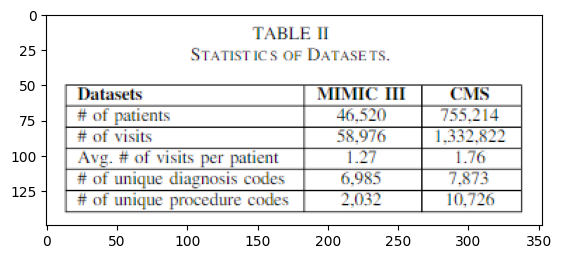

In [86]:
img = plt. imread('./Resuts1.PNG')
plt. imshow(img)

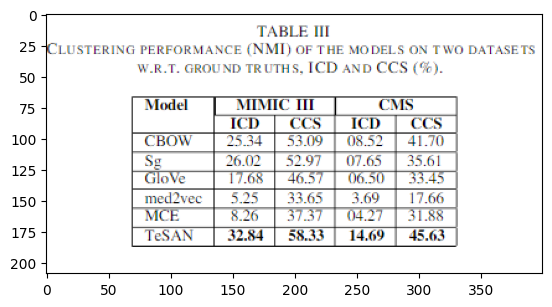

In [88]:
img = plt. imread('./Results2.PNG')
plt. imshow(img)

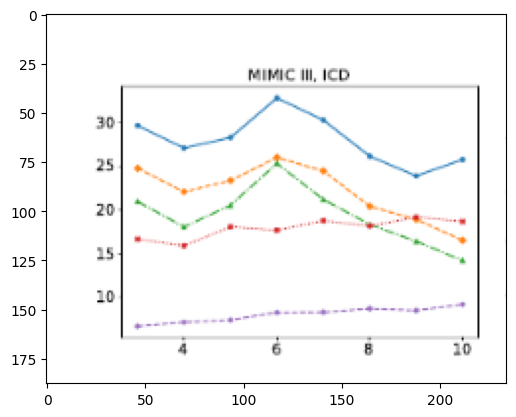

In [89]:
img = plt. imread('./Results3.PNG')
plt. imshow(img)

## Model comparison

When comparing the mdels and data sets it was found that CMS data lead to much more accurate resuts with a higher accuracy score. Simmilarly, CCS codes lead to higher accuracy then ICD scores. Ttherefore both of my Hypotthesis were apprioved. and the experiments failed to reject the set hypothesis.

# Discussion

Through the research it was found that although the paper is reproducible, the amount of work the paper puts ina dn covers is enormous. THerefore only parts of the paper was reproducable or the scale of this calss. Althought simmilar results were achived for clustering algorithm, the TESaN Algorithm was much harder to impleamnet and could be said to not be easily reproducable.
For the next phase of my research I would like to continue the reproduction of this paper by implementing the other algorithms other than clustering, and also implementing the TESaN Algorithm to compare results to the original paper.



# References
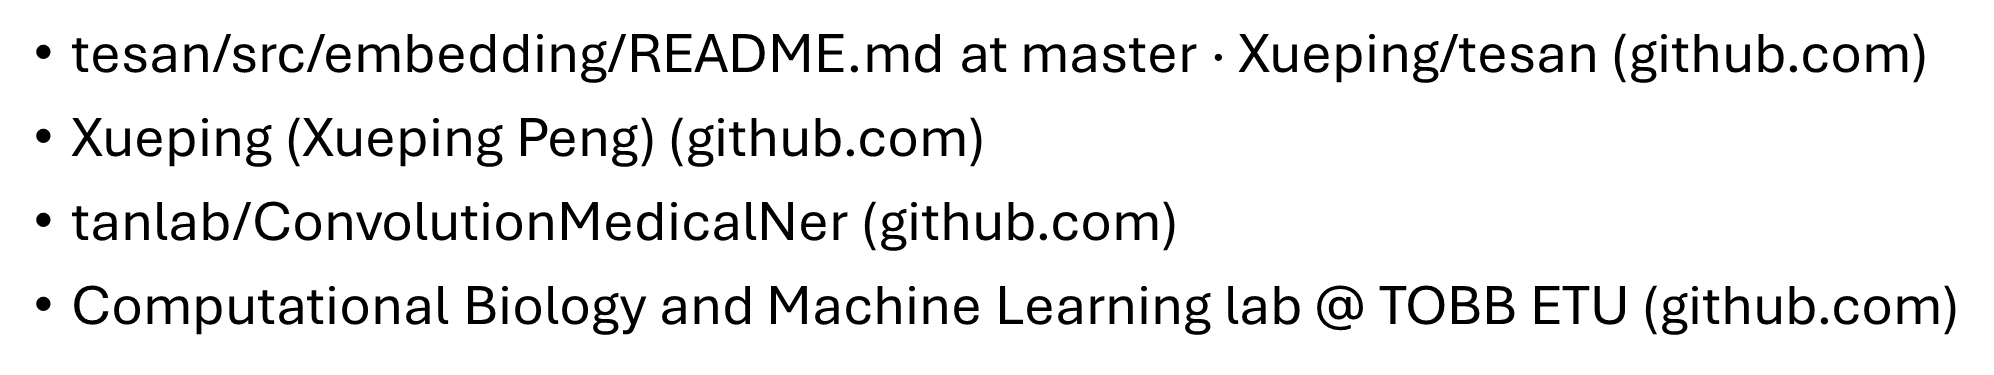
1.


# Feel free to add new sections